In [1]:
import sys
import os
import matplotlib.pyplot as plt
import cv2

import numpy as np

# Add the src directory to the path. TEMPORARY FIX
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../..")))

from src.data_processing.dataset_loader import CoastData
from src.data_processing.dataset_preprocessor import DatasetPreprocessor

from src.data_postprocessing import obtain_shoreline

In [2]:
# data_path = os.path.abspath(os.path.join(os.getcwd(), "../../data/processed_4_classes/"))

predictions_path = {
    "binary": os.path.abspath(os.path.join(os.getcwd(), "../../data/SCLabels_prediction_by_set_unet_binary/")),
    "three_classes": os.path.abspath(os.path.join(os.getcwd(), "../../data/SCLabels_prediction_by_set_unet_2025/")),
    "four_classes": os.path.abspath(os.path.join(os.getcwd(), "../../data/SCLabels_prediction_by_set_unet_4_classes/")),
}

data = {
    "binary": {
        "images": os.listdir(os.path.join(predictions_path["binary"], "images")),
        "masks": os.listdir(os.path.join(predictions_path["binary"], "masks")),
        "predicted_mask": os.listdir(os.path.join(predictions_path["binary"], "predicted_mask")),
    },
}

sation_names = ["agrelo", "arenaldentem", "cadiz", "cies", "samarador",]

print(data["binary"]["images"])

# Path of the test images organized by station
test_path = "images/test/"
test_images_path = {
    "agrelo": [],
    "arenaldentem": [],
    "cadiz": [],
    "cies": [],
    "samarador": [],
}

print(os.path.join(predictions_path["binary"], test_path))
print(len(os.listdir(os.path.join(predictions_path["binary"], test_path))))
binary_test_path = os.path.join(predictions_path["binary"], test_path)
for img_path in os.listdir(os.path.join(predictions_path["binary"], test_path)):
    
    if "agrelo" in img_path:
        test_images_path["agrelo"].append(img_path)
    elif "arenaldentem" in img_path:
        test_images_path["arenaldentem"].append(img_path)
    elif "cadiz" in img_path:
        test_images_path["cadiz"].append(img_path)
    elif "cies" in img_path:
        test_images_path["cies"].append(img_path)
    elif "samarador" in img_path:
        test_images_path["samarador"].append(img_path)

for station in sation_names:
    print(f"Station: {station}")
    print("length of test images path: ", len(test_images_path[station]))


['test', 'train', 'validation']
c:\Users\josep\Documents\SOCIB\Shoreline-extraction\data\SCLabels_prediction_by_set_unet_binary\images/test/
174
Station: agrelo
length of test images path:  25
Station: arenaldentem
length of test images path:  4
Station: cadiz
length of test images path:  95
Station: cies
length of test images path:  44
Station: samarador
length of test images path:  6


In [3]:
from scipy.spatial import cKDTree

def compute_distance(mask_pred, mask_gt, shoreline_class=1, predicted_shoreline_class=1):
    coords_pred = np.column_stack(np.where(mask_pred == predicted_shoreline_class))
    coords_gt = np.column_stack(np.where(mask_gt == shoreline_class))

    # Distance from predicted to GT
    # Create a KDTree for the Ground Truth coordinates
    tree_gt = cKDTree(coords_gt)

    # Find the nearest neighbors in the Ground Truth for each coordinate in the predicted mask
    dists_pred_to_gt, _ = tree_gt.query(coords_pred)

    # Distance from GT to predicted
    # Create a KDTree for the predicted coordinates
    tree_pred = cKDTree(coords_pred)
    # Find the nearest neighbors in the predicted for each coordinate in the GT mask
    dists_gt_to_pred, _ = tree_pred.query(coords_gt)

    return dists_pred_to_gt, dists_gt_to_pred

In [18]:
CLASS_COLORS = {
    'NoData': (0, 0, 0),        # (black)
    'Landwards': (139, 69, 19), # (brown)
    'Seawards': (0, 0, 255),    # (blue)
    'Shoreline': (0, 255, 0),   # (green)
    'Predicted_Shoreline': (255, 0, 0), # (red)
    'Coincidence': (255, 255, 0) # (yellow)
}

# Define a custom colormap for the mask
def apply_custom_colormap(mask):
    # Create an RGB image initialized to black
    colored_mask = np.zeros((*mask.shape, 3), dtype=np.uint8)

    # Assign colors based on class values
    colored_mask[mask == 0] = CLASS_COLORS["NoData"]
    colored_mask[mask == 2] = CLASS_COLORS["Seawards"]
    colored_mask[mask == 1] = CLASS_COLORS["Landwards"]
    colored_mask[mask == 3] = CLASS_COLORS["Shoreline"]

    return colored_mask

def crop_center(image, crop_size, start):
    h, w = image.shape[:2]
    crop_w, crop_h = crop_size
    start_x, start_y = start

    end_x = start_x + crop_w
    end_y = start_y + crop_h

    return image[start_y:end_y, start_x:end_x]

def apply_masks(image, mask, predicted_mask, shoreline_pixel_mask, shoreline_pixel_predicted_mask):
    # Copy original image
    overlay = image.copy()

    alpha = 0.6

    green = np.array([0, 255, 0], dtype=np.uint8)     # Shoreline
    red = np.array([255, 0, 0], dtype=np.uint8)       # Predicted shoreline
    yellow = np.array([255, 255, 0], dtype=np.uint8)  # Coincidència

    # Create masks for shoreline pixels
    only_shoreline = (mask == shoreline_pixel_mask) & (predicted_mask != shoreline_pixel_predicted_mask)
    only_predicted = (mask != shoreline_pixel_mask) & (predicted_mask == shoreline_pixel_predicted_mask)
    both = (mask == shoreline_pixel_mask) & (predicted_mask == shoreline_pixel_predicted_mask)

    # Apply colors to the overlay
    overlay[only_shoreline] = (
        alpha * green + (1 - alpha) * overlay[only_shoreline]
    ).astype(np.uint8)

    overlay[only_predicted] = (
        alpha * red + (1 - alpha) * overlay[only_predicted]
    ).astype(np.uint8)

    overlay[both] = (
        alpha * yellow + (1 - alpha) * overlay[both]
    ).astype(np.uint8)

    return overlay


# For the 3 classes
def find_shoreline(pred, land_pixel, sea_pixel):
    shoreline = np.zeros_like(pred)
    for i in range(pred.shape[0]):
        for j in range(1, pred.shape[1]):
            if pred[i, j] == land_pixel and pred[i, j-1] == sea_pixel:
                shoreline[i, j] = 1
            if pred[i, j] == sea_pixel and pred[i, j-1] == land_pixel:
                shoreline[i, j-1] = 1

    for j in range(pred.shape[1]):
        for i in range(1, pred.shape[0]):
            if pred[i, j] == land_pixel and pred[i-1, j] == sea_pixel:
                shoreline[i, j] = 1
            if pred[i, j] == sea_pixel and pred[i-1, j] == land_pixel:
                shoreline[i-1, j] = 1
            
    return shoreline

def find_largest_contour(shoreline_mask):
    # Find contours in the shoreline mask
    contours, _ = cv2.findContours(shoreline_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if len(contours) == 0:
        return None

    # Find the largest contour based on the number of points
    largest_contour = max(contours, key=len)

    return largest_contour

def get_image(predictions_path, test_images_path, station, index, shoreline_pixel_mask, shoreline_pixel_predicted_mask, start_crop = [0, 0], crop_size=(256, 256), three_classes=False, bilstm = False, raw_distance=False):
    path_img = os.path.join(predictions_path, "images/test",test_images_path[station][index])
    img = cv2.imread(path_img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Read mask
    path_mask = os.path.join(predictions_path, "masks/test",test_images_path[station][index].replace("image.jpg", "mask.png"))
    mask = cv2.imread(path_mask, cv2.IMREAD_GRAYSCALE)

    # Read predicted mask
    path_predicted_mask = os.path.join(predictions_path, "predicted_mask/test",test_images_path[station][index].replace("image.jpg", "mask.png"))
    if three_classes:
        predicted_mask = obtain_shoreline.transform_mask_to_shoreline(pred_path = path_predicted_mask, landward=1, seaward=2)
        mask[mask == 3] = 1  # Convert shoreline class to landward class
        mask = obtain_shoreline.transform_mask_to_shoreline_from_img(pred = mask, landward=1, seaward=2)
        new_mask = np.zeros_like(mask)
        new_mask[mask == 1] = shoreline_pixel_mask  # Landward
        mask = new_mask
    elif bilstm:
        predicted_mask  = obtain_shoreline.transform_mask_to_shoreline(pred_path = path_predicted_mask, landward=0, seaward=1)    
        mask  = obtain_shoreline.transform_mask_to_shoreline(pred_path = path_mask, landward=0, seaward=1)
    else:
        predicted_mask = cv2.imread(path_predicted_mask, cv2.IMREAD_GRAYSCALE)

    distance = compute_distance(predicted_mask, mask, shoreline_class=shoreline_pixel_mask, predicted_shoreline_class=shoreline_pixel_predicted_mask)
    if raw_distance:
        return distance

    combined_image = apply_masks(img, mask, predicted_mask, shoreline_pixel_mask=shoreline_pixel_mask, shoreline_pixel_predicted_mask=shoreline_pixel_predicted_mask)

    # Crop image and mask
    combined_image = crop_center(combined_image, crop_size, start_crop)

    # Format texts
    mad_p2g = np.mean(distance[0])
    mad_g2p = np.mean(distance[1])
    ratio = len(distance[0]) / len(distance[1]) if len(distance[1]) > 0 else 0

    text1 = f"MAD P->G: {mad_p2g:.2f}"
    text2 = f"MAD G->P: {mad_g2p:.2f}"
    text3 = f"Ratio: {ratio:.2f}"

    # Font settings
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 0.37
    font_color = (255, 255, 255)
    thickness = 1
    margin = 10
    spacing = 5

    # Text sizes
    (tw1, th1), _ = cv2.getTextSize(text1, font, font_scale, thickness)
    (tw2, th2), _ = cv2.getTextSize(text2, font, font_scale, thickness)
    (tw3, th3), _ = cv2.getTextSize(text3, font, font_scale, thickness)

    # Determine maximum text width for alignment
    text_width = max(tw1, tw2, tw3)

    # Image size
    img_h, img_w, _ = combined_image.shape

    # Coordinates (bottom right corner, aligned left)
    x = img_w - text_width - margin
    y3 = img_h - margin
    y2 = y3 - th3 - spacing
    y1 = y2 - th2 - spacing

    # Draw semi-transparent rectangle
    overlay = combined_image.copy()
    cv2.rectangle(
        overlay,
        (x - 5, y1 - th1 - 5),
        (img_w, img_h),
        (0, 0, 0),
        -1
    )
    alpha = 0.3  # transparency factor
    combined_image = cv2.addWeighted(overlay, alpha, combined_image, 1 - alpha, 0)

    # Draw texts
    cv2.putText(combined_image, text1, (x, y1), font, font_scale, font_color, thickness, cv2.LINE_AA)
    cv2.putText(combined_image, text2, (x, y2), font, font_scale, font_color, thickness, cv2.LINE_AA)
    cv2.putText(combined_image, text3, (x, y3), font, font_scale, font_color, thickness, cv2.LINE_AA)
    return combined_image   

config = {
    "agrelo": {
        "start": [250, 100],
    }, 
    "arenaldentem": {
        "start": [40, 0],
    },
    "cadiz": {
        "start": [120, 0],
    },
    "cies": {
        "start": [105, 0],
    },
    "samarador": {
        "start": [0, 0],
    }
}    

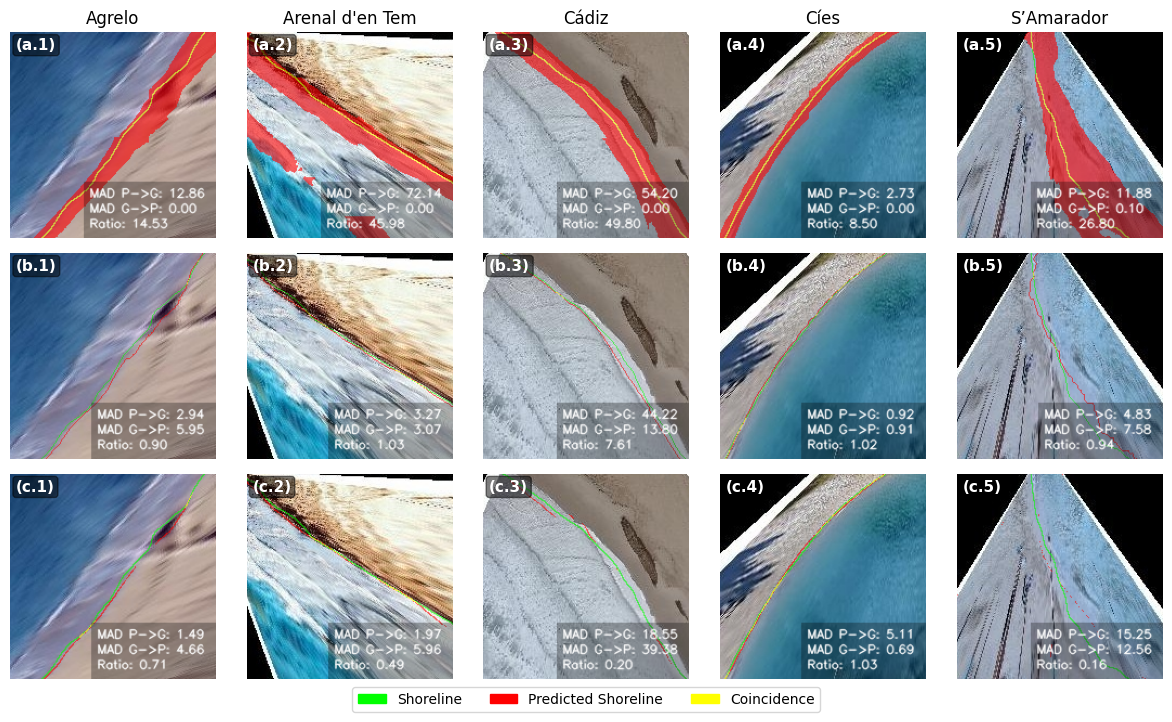

In [5]:

import matplotlib.patches as mpatches

# Replace this with your actual station list and data structure
station_names = list(config.keys())
labels = ['(a.1)', '(a.2)', '(a.3)', '(a.4)', '(a.5)', '(b.1)', '(b.2)', '(b.3)', '(b.4)', '(b.5)', '(c.1)', '(c.2)', '(c.3)', '(c.4)', '(c.5)']

# Define the crop size (width x height)
crop_size = (190, 190)  # Width x Height


# Create the figure
fig, axes = plt.subplots(3, len(station_names), figsize=(12, 7))  # Slightly wider

title_station_names = ["Agrelo", "Arenal d'en Tem", "Cádiz", "Cíes", "S’Amarador"]

index_station = {
    "agrelo": 6,
    "arenaldentem": 2,
    "cadiz": 8,
    "cies": 9,
    "samarador": 0,
}

# Loop over stations
for i, station in enumerate(station_names):
    index = index_station[station]
    # Read image
    img_crop_binary = get_image(predictions_path["binary"], test_images_path, station, index, shoreline_pixel_mask = 1, shoreline_pixel_predicted_mask = 1, start_crop=config[station]['start'], crop_size=crop_size)
    img_crop = get_image(predictions_path["three_classes"], test_images_path, station, index, shoreline_pixel_mask = 3, shoreline_pixel_predicted_mask = 1, start_crop=config[station]['start'], crop_size=crop_size, three_classes=True)
    img_crop_4_classes = get_image(predictions_path["four_classes"], test_images_path, station, index, shoreline_pixel_mask = 3, shoreline_pixel_predicted_mask = 3, start_crop=config[station]['start'], crop_size=crop_size)
    

    # Top row: RGB image
    axes[0,i].imshow(img_crop_binary)
    axes[0,i].axis('off')
    axes[0,i].set_title(title_station_names[i])
    
    axes[1,i].imshow(img_crop)
    axes[1,i].axis('off')
    # axes[1,i].set_title(station)

    
    axes[2,i].imshow(img_crop_4_classes)
    axes[2,i].axis('off')
    # axes[2,i].set_title(station)



    # # Bottom row: mask
    # axes[1, i].imshow(colored_mask)
    # axes[1, i].axis('off')

    # # Add text labels
    # axes[i].text(5, 30, labels[i], fontsize=11, color='white', weight='bold', bbox=dict(facecolor='black', alpha=0.5, boxstyle='round,pad=0.2'))
    axes[0, i].text(5, 16, labels[i], fontsize=11, color='white', weight='bold', bbox=dict(facecolor='black', alpha=0.5, boxstyle='round,pad=0.2'))
    axes[1, i].text(5, 16, labels[i+5], fontsize=11, color='white', weight='bold', bbox=dict(facecolor='black', alpha=0.5, boxstyle='round,pad=0.2'))
    axes[2, i].text(5, 16, labels[i+10], fontsize=11, color='white', weight='bold', bbox=dict(facecolor='black', alpha=0.5, boxstyle='round,pad=0.2'))

# Add color legend below the figure
legend_patches = [
    mpatches.Patch(color=np.array(CLASS_COLORS['Shoreline'])/255, label='Shoreline'),
    mpatches.Patch(color=np.array(CLASS_COLORS['Predicted_Shoreline'])/255, label='Predicted Shoreline'),
    mpatches.Patch(color=np.array(CLASS_COLORS['Coincidence'])/255, label='Coincidence'),
]
fig.legend(handles=legend_patches, loc='lower center', ncol=4, bbox_to_anchor=(0.5, -0.035))

# Layout
plt.tight_layout()
plt.show()

# Save the figure
fig.savefig(os.path.join("img", "example_prediction.png"), bbox_inches='tight', dpi=300)

# Experiment 2

In [6]:
# data_path = os.path.abspath(os.path.join(os.getcwd(), "../../data/processed_4_classes/"))

predictions_path = {
    "binary": os.path.abspath(os.path.join(os.getcwd(), "../../data/SCLabels_prediction_by_set_deeplab_binary_0.9674/"))
}

data = {
    "binary": {
        "images": os.listdir(os.path.join(predictions_path["binary"], "images")),
        "masks": os.listdir(os.path.join(predictions_path["binary"], "masks")),
        "predicted_mask": os.listdir(os.path.join(predictions_path["binary"], "predicted_mask")),
    },
}

sation_names = ["agrelo", "arenaldentem", "cadiz", "cies", "samarador",]

print(data["binary"]["images"])

# Path of the test images organized by station
test_path = "images/test/"
test_images_path = {
    "agrelo": [],
    "arenaldentem": [],
    "cadiz": [],
    "cies": [],
    "samarador": [],
}

print(os.path.join(predictions_path["binary"], test_path))
print(len(os.listdir(os.path.join(predictions_path["binary"], test_path))))
binary_test_path = os.path.join(predictions_path["binary"], test_path)
for img_path in os.listdir(os.path.join(predictions_path["binary"], test_path)):

    if "agrelo" in img_path:
        test_images_path["agrelo"].append(img_path)
    elif "arenaldentem" in img_path:
        test_images_path["arenaldentem"].append(img_path)
    elif "cadiz" in img_path:
        test_images_path["cadiz"].append(img_path)
    elif "cies" in img_path:
        test_images_path["cies"].append(img_path)
    elif "samarador" in img_path:
        test_images_path["samarador"].append(img_path)

for station in sation_names:
    print(f"Station: {station}")
    print("length of test images path: ", len(test_images_path[station]))


['test', 'train', 'validation']
c:\Users\josep\Documents\SOCIB\Shoreline-extraction\data\SCLabels_prediction_by_set_deeplab_binary_0.9674\images/test/
174
Station: agrelo
length of test images path:  25
Station: arenaldentem
length of test images path:  4
Station: cadiz
length of test images path:  95
Station: cies
length of test images path:  44
Station: samarador
length of test images path:  6


In [7]:
import numpy as np

def obtain_best_worst_predictions(station_names, test_images_path, predictions_path,
                                   shoreline_pixel_mask=1, shoreline_pixel_predicted_mask=1,
                                   three_classes=False, bilstm=False, crop_size=(256, 256)):
    best_indexes = dict.fromkeys(station_names, 0)
    second_best_indexes = dict.fromkeys(station_names, 0)
    worst_indexes = dict.fromkeys(station_names, 0)

    best_mad = dict.fromkeys(station_names, float('inf'))
    second_best_mad = dict.fromkeys(station_names, float('inf'))
    worst_mad = dict.fromkeys(station_names, 0.0)

    for station in station_names:
        for i in range(len(test_images_path[station])):
            # Compute the MAD distance
            dist_p2g, dist_g2p = get_image(predictions_path, test_images_path, station, i,
                                           shoreline_pixel_mask=shoreline_pixel_mask,
                                           shoreline_pixel_predicted_mask=shoreline_pixel_predicted_mask,
                                           three_classes=three_classes, bilstm=bilstm, raw_distance=True)
            mean_mad = (np.mean(dist_p2g) + np.mean(dist_g2p)) / 2

            # Update best and second best
            if mean_mad < best_mad[station]:
                second_best_indexes[station] = best_indexes[station]
                second_best_mad[station] = best_mad[station]
                best_indexes[station] = i
                best_mad[station] = mean_mad
            elif mean_mad < second_best_mad[station]:
                second_best_indexes[station] = i
                second_best_mad[station] = mean_mad

            # Update worst
            if mean_mad > worst_mad[station]:
                worst_indexes[station] = i
                worst_mad[station] = mean_mad

    print("Best indexes:", best_indexes)
    print("Second best indexes:", second_best_indexes)
    print("Worst indexes:", worst_indexes)
    print("Best MAD:", best_mad)
    print("Second best MAD:", second_best_mad)
    print("Worst MAD:", worst_mad)

    return best_indexes, second_best_indexes, worst_indexes, best_mad, second_best_mad, worst_mad



In [8]:
best_indexes, second_best_indexes, worst_indexes, best_mad, second_best_mad, worst_mad = obtain_best_worst_predictions(sation_names, test_images_path, predictions_path=predictions_path["binary"])

Best indexes: {'agrelo': 16, 'arenaldentem': 1, 'cadiz': 38, 'cies': 28, 'samarador': 4}
Second best indexes: {'agrelo': 6, 'arenaldentem': 0, 'cadiz': 42, 'cies': 1, 'samarador': 3}
Worst indexes: {'agrelo': 7, 'arenaldentem': 3, 'cadiz': 62, 'cies': 16, 'samarador': 5}
Best MAD: {'agrelo': np.float64(1.2211272449202442), 'arenaldentem': np.float64(4.245933268130975), 'cadiz': np.float64(2.2278607716949583), 'cies': np.float64(0.6996520488238365), 'samarador': np.float64(3.0937307154700955)}
Second best MAD: {'agrelo': np.float64(1.4734067883668205), 'arenaldentem': np.float64(4.2475013946676), 'cadiz': np.float64(5.9180888595859225), 'cies': np.float64(0.7250957134218345), 'samarador': np.float64(3.764375447479226)}
Worst MAD: {'agrelo': np.float64(10.704808800538812), 'arenaldentem': np.float64(20.476313180011477), 'cadiz': np.float64(182.6078104969567), 'cies': np.float64(6.748961714217401), 'samarador': np.float64(9.579432544940584)}


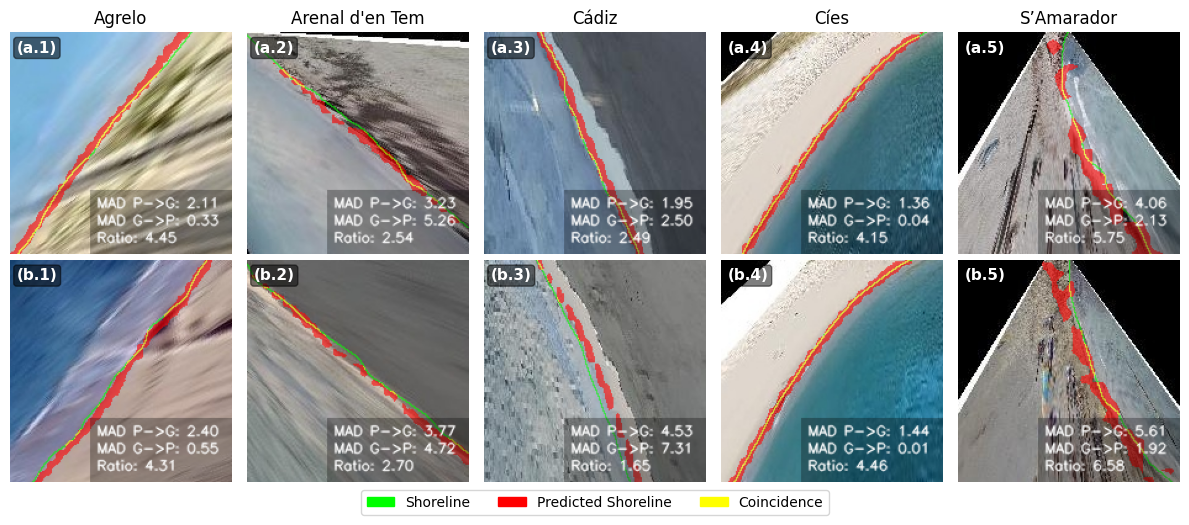

In [9]:
import matplotlib.patches as mpatches

# Replace this with your actual station list and data structure
station_names = list(config.keys())
labels = ['(a.1)', '(a.2)', '(a.3)', '(a.4)', '(a.5)', '(b.1)', '(b.2)', '(b.3)', '(b.4)', '(b.5)']

# Define the crop size (width x height)
crop_size = (180, 180)  # Width x Height

# Create the figure
fig, axes = plt.subplots(2, len(station_names), figsize=(12, 5))  # Slightly wider

title_station_names = ["Agrelo", "Arenal d'en Tem", "Cádiz", "Cíes", "S’Amarador"]

config = {
    "agrelo": {
        "best_start": [250, 100],
        "best_second_start": [270, 100]
    }, 
    "arenaldentem": {
        "best_start": [60, 0],
        "best_second_start": [140, 70]
    },
    "cadiz": {
        "best_start": [240, 200],
        "best_second_start": [240, 200]
    },
    "cies": {
        "best_start": [150, 0],
        "best_second_start": [90, 0]
    },
    "samarador": {
        "best_start": [0, 0],
        "best_second_start": [0, 0]
    }
}


# Loop over stations
for i, station in enumerate(station_names):
    best_index = best_indexes[station]
    # Read image
    img_crop_binary = get_image(predictions_path["binary"], test_images_path, station, best_index, shoreline_pixel_mask = 1, shoreline_pixel_predicted_mask = 1, start_crop=config[station]['best_start'], crop_size=crop_size)
    
    # worst_index = worst_indexes[station]
    worst_index = second_best_indexes[station]  # Use the index from the config for worst case
    # print(config[station]['start'])
    img_crop_binary_worst = get_image(predictions_path["binary"], test_images_path, station, worst_index, shoreline_pixel_mask = 1, shoreline_pixel_predicted_mask = 1, start_crop=config[station]['best_second_start'], crop_size=crop_size)

    # Top row: RGB image
    axes[0][i].imshow(img_crop_binary)
    axes[0][i].axis('off')
    axes[0][i].set_title(title_station_names[i])
    axes[0][i].text(5, 16, labels[i], fontsize=11, color='white', weight='bold', bbox=dict(facecolor='black', alpha=0.5, boxstyle='round,pad=0.2'))

    axes[1][i].imshow(img_crop_binary_worst)
    axes[1][i].axis('off')
    # axes[1][i].set_title(title_station_names[i])
    axes[1][i].text(5, 16, labels[i+5], fontsize=11, color='white', weight='bold', bbox=dict(facecolor='black', alpha=0.5, boxstyle='round,pad=0.2'))

# Add color legend below the figure
legend_patches = [
    mpatches.Patch(color=np.array(CLASS_COLORS['Shoreline'])/255, label='Shoreline'),
    mpatches.Patch(color=np.array(CLASS_COLORS['Predicted_Shoreline'])/255, label='Predicted Shoreline'),
    mpatches.Patch(color=np.array(CLASS_COLORS['Coincidence'])/255, label='Coincidence'),
]
fig.legend(handles=legend_patches, loc='lower center', ncol=4, bbox_to_anchor=(0.5, -0.045))

# Layout
plt.tight_layout()
plt.show()

# Save the figure
fig.savefig(os.path.join("img", "example_prediction_binary_deeplab.png"), bbox_inches='tight', dpi=300)

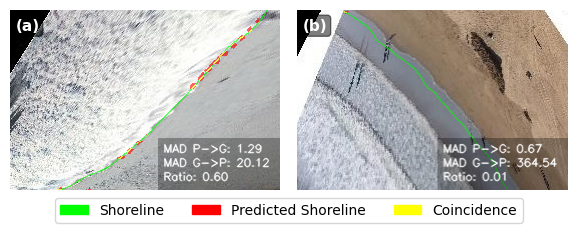

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import os

selected_stations = ["agrelo", "cadiz"]
labels = ['(a)', '(b)']

crop_size = (270, 180)

config = {
    "agrelo": {
        "start": [75, 250]
    }, 
    "arenaldentem": {
        "start": [60, 150]
    },
    "cadiz": {
        "start": [80, 000]
    },
    "cies": {
        "start": [90, 0]
    },
    "samarador": {
        "start": [0, 0]
    }
}

fig, axes = plt.subplots(1, 2, figsize=(5.9, 2.1))

for i, station in enumerate(selected_stations):
    index = worst_indexes[station]
    start_crop = config[station]['start']

    img_crop = get_image(predictions_path["binary"], test_images_path, station, index,
                         shoreline_pixel_mask=1,
                         shoreline_pixel_predicted_mask=1,
                         start_crop=start_crop,
                         crop_size=crop_size)

    axes[i].imshow(img_crop)
    axes[i].axis('off')
    axes[i].text(5, 20, labels[i], fontsize=11, color='white', weight='bold',
                 bbox=dict(facecolor='black', alpha=0.5, boxstyle='round,pad=0.2'))

legend_patches = [
    mpatches.Patch(color=np.array(CLASS_COLORS['Shoreline']) / 255, label='Shoreline'),
    mpatches.Patch(color=np.array(CLASS_COLORS['Predicted_Shoreline']) / 255, label='Predicted Shoreline'),
    mpatches.Patch(color=np.array(CLASS_COLORS['Coincidence']) / 255, label='Coincidence'),
]
fig.legend(handles=legend_patches, loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.12))

plt.tight_layout()

plt.show()
fig.savefig(os.path.join("img", "example_bad_predictions_one_class.png"), bbox_inches='tight', dpi=300)

# Experiment 3

In [9]:
# data_path = os.path.abspath(os.path.join(os.getcwd(), "../../data/processed_4_classes/"))

predictions_path = {
    "unet": os.path.abspath(os.path.join(os.getcwd(), "../../data/SCLabels_prediction_by_set_unet_2025/")),
    "attention_unet": os.path.abspath(os.path.join(os.getcwd(), "../../data/SCLabels_prediction_by_set_attention_unet/")),
    "deeplabv3": os.path.abspath(os.path.join(os.getcwd(), "../../data/SCLabels_prediction_by_set_deeplab/")),
    "ducknet": os.path.abspath(os.path.join(os.getcwd(), "../../data/SCLabels_prediction_by_set_duck_net_256x256/")),
}

data = {
    "binary": {
        "images": os.listdir(os.path.join(predictions_path["unet"], "images")),
        "masks": os.listdir(os.path.join(predictions_path["unet"], "masks")),
        "predicted_mask": os.listdir(os.path.join(predictions_path["unet"], "predicted_mask")),
    },
}

sation_names = ["agrelo", "arenaldentem", "cadiz", "cies", "samarador",]


# Path of the test images organized by station
test_path = "images/test/"
test_images_path = {
    "agrelo": [],
    "arenaldentem": [],
    "cadiz": [],
    "cies": [],
    "samarador": [],
}

print(os.path.join(predictions_path["unet"], test_path))
print(len(os.listdir(os.path.join(predictions_path["unet"], test_path))))
binary_test_path = os.path.join(predictions_path["unet"], test_path)
for img_path in os.listdir(os.path.join(predictions_path["unet"], test_path)):
    
    if "agrelo" in img_path:
        test_images_path["agrelo"].append(img_path)
    elif "arenaldentem" in img_path:
        test_images_path["arenaldentem"].append(img_path)
    elif "cadiz" in img_path:
        test_images_path["cadiz"].append(img_path)
    elif "cies" in img_path:
        test_images_path["cies"].append(img_path)
    elif "samarador" in img_path:
        test_images_path["samarador"].append(img_path)

for station in sation_names:
    print(f"Station: {station}")
    print("length of test images path: ", len(test_images_path[station]))


c:\Users\josep\Documents\SOCIB\Shoreline-extraction\data\SCLabels_prediction_by_set_unet_2025\images/test/
174
Station: agrelo
length of test images path:  25
Station: arenaldentem
length of test images path:  4
Station: cadiz
length of test images path:  95
Station: cies
length of test images path:  44
Station: samarador
length of test images path:  6


In [10]:
best_indexes, second_best_indexes, worst_indexes, best_mad, second_best_mad, worst_mad = obtain_best_worst_predictions(sation_names, test_images_path, predictions_path=predictions_path["deeplabv3"], shoreline_pixel_mask = 3, shoreline_pixel_predicted_mask = 1, three_classes=True)

Best indexes: {'agrelo': 22, 'arenaldentem': 1, 'cadiz': 52, 'cies': 24, 'samarador': 2}
Second best indexes: {'agrelo': 20, 'arenaldentem': 2, 'cadiz': 57, 'cies': 18, 'samarador': 4}
Worst indexes: {'agrelo': 8, 'arenaldentem': 0, 'cadiz': 1, 'cies': 15, 'samarador': 5}
Best MAD: {'agrelo': np.float64(1.9385031492105074), 'arenaldentem': np.float64(2.4963999415819473), 'cadiz': np.float64(2.0594808543618077), 'cies': np.float64(0.6868338566513952), 'samarador': np.float64(2.036075889100302)}
Second best MAD: {'agrelo': np.float64(2.570188112560505), 'arenaldentem': np.float64(3.8385255836479306), 'cadiz': np.float64(2.08011169430465), 'cies': np.float64(0.7413187042996192), 'samarador': np.float64(3.3215845698948345)}
Worst MAD: {'agrelo': np.float64(46.5801816230319), 'arenaldentem': np.float64(4.421174438559989), 'cadiz': np.float64(33.45949503226855), 'cies': np.float64(3.666373058727844), 'samarador': np.float64(8.906120270300162)}


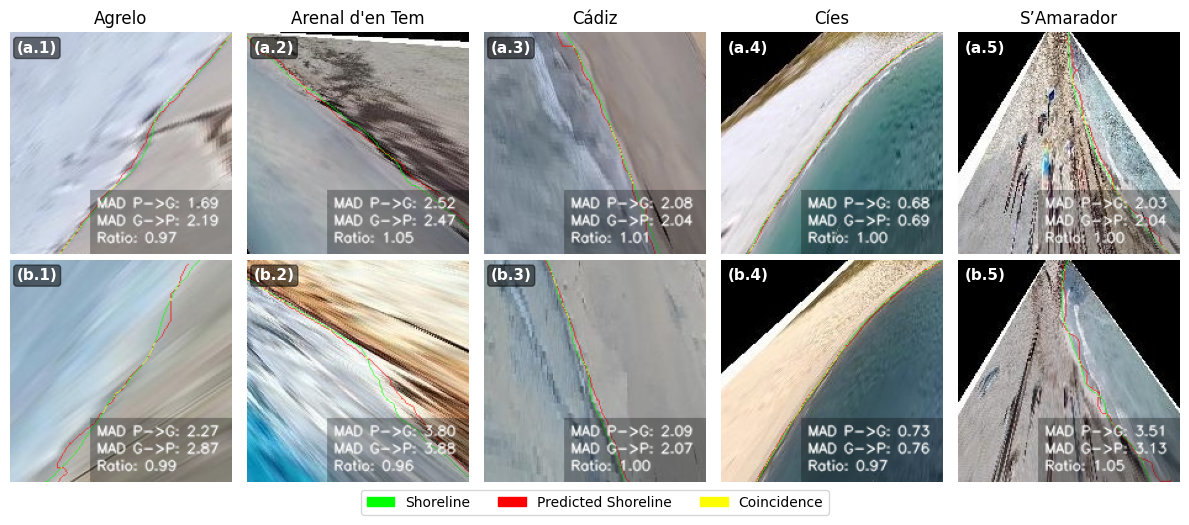

In [ ]:
import matplotlib.patches as mpatches

station_names = list(config.keys())
labels = ['(a.1)', '(a.2)', '(a.3)', '(a.4)', '(a.5)', '(b.1)', '(b.2)', '(b.3)', '(b.4)', '(b.5)']

# Define the crop size (width x height)
crop_size = (180, 180)  # Width x Height

# Create the figure
fig, axes = plt.subplots(2, len(station_names), figsize=(12, 5))  # Slightly wider

title_station_names = ["Agrelo", "Arenal d'en Tem", "Cádiz", "Cíes", "S’Amarador"]

config = {
    "agrelo": {
        "best_start": [250, 100],
        "best_second_start": [250, 0]
    }, 
    "arenaldentem": {
        "best_start": [60, 0],
        "best_second_start": [140, 70]
    },
    "cadiz": {
        "best_start": [270, 220],
        "best_second_start": [150, 200]
    },
    "cies": {
        "best_start": [120, 0],
        "best_second_start": [90, 0]
    },
    "samarador": {
        "best_start": [0, 0],
        "best_second_start": [0, 0]
    }
}


# Loop over stations
for i, station in enumerate(station_names):
    best_index = best_indexes[station]
    # Read image
    img_crop_binary = get_image(predictions_path["deeplabv3"], test_images_path, station, best_index, shoreline_pixel_mask = 3, shoreline_pixel_predicted_mask = 1, start_crop=config[station]['best_start'], crop_size=crop_size, three_classes=True)

    # worst_index = worst_indexes[station]
    second_best_index = second_best_indexes[station]  # Use the index from the config for worst case
    # print(config[station]['start'])
    img_crop_binary_second = get_image(predictions_path["deeplabv3"], test_images_path, station, second_best_index, shoreline_pixel_mask = 3, shoreline_pixel_predicted_mask = 1, start_crop=config[station]['best_second_start'], crop_size=crop_size, three_classes=True)

    # Top row: RGB image
    axes[0][i].imshow(img_crop_binary)
    axes[0][i].axis('off')
    axes[0][i].set_title(title_station_names[i])
    axes[0][i].text(5, 16, labels[i], fontsize=11, color='white', weight='bold', bbox=dict(facecolor='black', alpha=0.5, boxstyle='round,pad=0.2'))

    axes[1][i].imshow(img_crop_binary_second)
    axes[1][i].axis('off')
    # axes[1][i].set_title(title_station_names[i])
    axes[1][i].text(5, 16, labels[i+5], fontsize=11, color='white', weight='bold', bbox=dict(facecolor='black', alpha=0.5, boxstyle='round,pad=0.2'))

# Add color legend below the figure
legend_patches = [
    mpatches.Patch(color=np.array(CLASS_COLORS['Shoreline'])/255, label='Shoreline'),
    mpatches.Patch(color=np.array(CLASS_COLORS['Predicted_Shoreline'])/255, label='Predicted Shoreline'),
    mpatches.Patch(color=np.array(CLASS_COLORS['Coincidence'])/255, label='Coincidence'),
]
fig.legend(handles=legend_patches, loc='lower center', ncol=4, bbox_to_anchor=(0.5, -0.045))

# Layout
plt.tight_layout()
plt.show()

# Save the figure
fig.savefig(os.path.join("img", "example_prediction_three_classes_deeplab.png"), bbox_inches='tight', dpi=300)

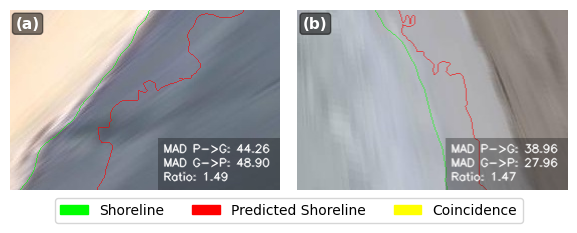

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import os

selected_stations = ["agrelo", "cadiz"]
labels = ['(a)', '(b)']

crop_size = (270, 180)

config = {
    "agrelo": {
        "start": [250, 100]
    }, 
    "arenaldentem": {
        "start": [60, 0]
    },
    "cadiz": {
        "start": [220, 300]
    },
    "cies": {
        "start": [90, 0]
    },
    "samarador": {
        "start": [0, 0]
    }
}

fig, axes = plt.subplots(1, 2, figsize=(5.9, 2.1))

for i, station in enumerate(selected_stations):
    index = worst_indexes[station]
    start_crop = config[station]['start']
    
    img_crop = get_image(predictions_path["deeplabv3"], test_images_path, station, index,
                         shoreline_pixel_mask=3,
                         shoreline_pixel_predicted_mask=1,
                         start_crop=start_crop,
                         crop_size=crop_size,
                         three_classes=True)

    axes[i].imshow(img_crop)
    axes[i].axis('off')
    axes[i].text(5, 18, labels[i], fontsize=11, color='white', weight='bold',
                 bbox=dict(facecolor='black', alpha=0.5, boxstyle='round,pad=0.2'))

legend_patches = [
    mpatches.Patch(color=np.array(CLASS_COLORS['Shoreline']) / 255, label='Shoreline'),
    mpatches.Patch(color=np.array(CLASS_COLORS['Predicted_Shoreline']) / 255, label='Predicted Shoreline'),
    mpatches.Patch(color=np.array(CLASS_COLORS['Coincidence']) / 255, label='Coincidence'),
]
fig.legend(handles=legend_patches, loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.12))

plt.tight_layout()

plt.show()
fig.savefig(os.path.join("img", "example_bad_predictions_three_classes_deeplab.png"), bbox_inches='tight', dpi=300)


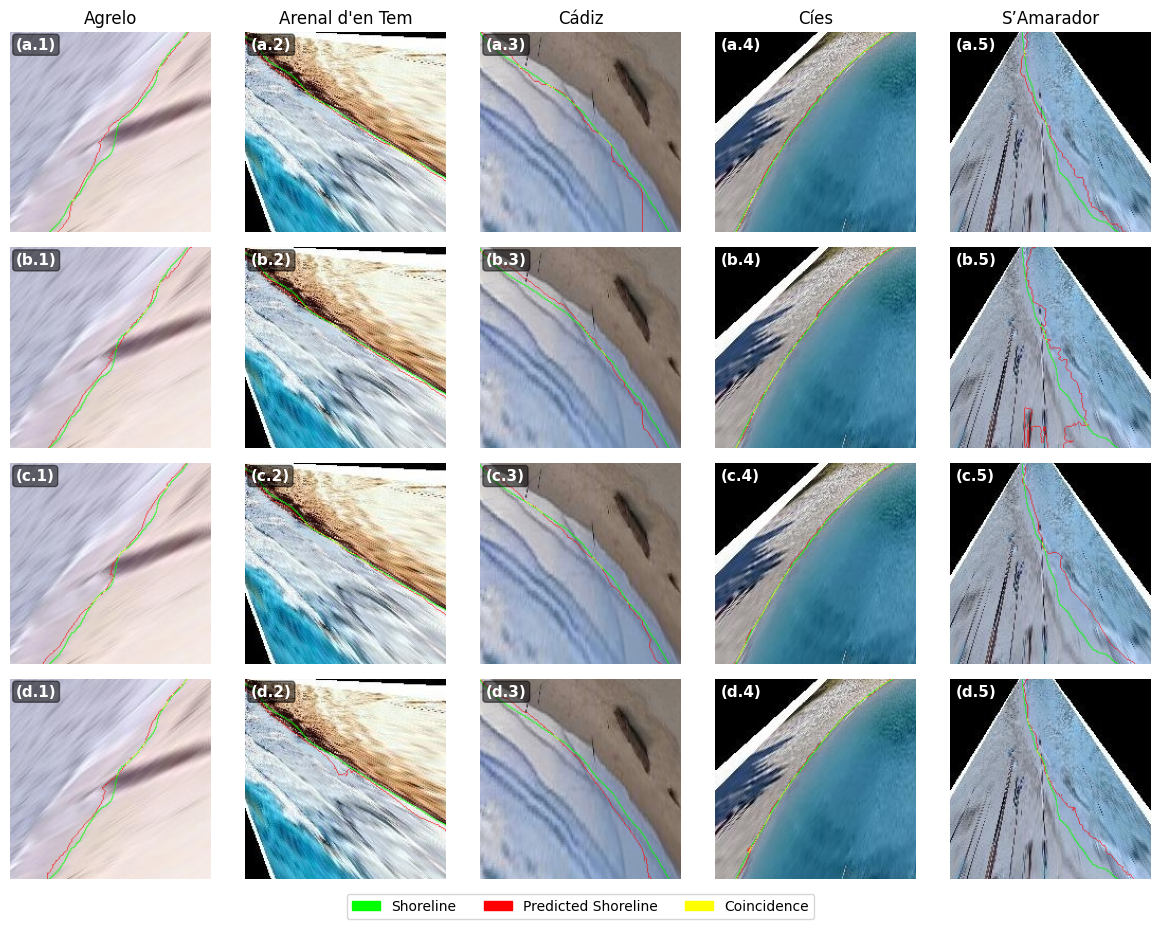

In [15]:

import matplotlib.patches as mpatches

# Replace this with your actual station list and data structure
station_names = list(config.keys())
labels = ['(a.1)', '(a.2)', '(a.3)', '(a.4)', '(a.5)', '(b.1)', '(b.2)', '(b.3)', '(b.4)', '(b.5)', '(c.1)', '(c.2)', '(c.3)', '(c.4)', '(c.5)', '(d.1)', '(d.2)', '(d.3)', '(d.4)', '(d.5)']

# Define the crop size (width x height)
crop_size = (190, 190)  # Width x Height

# Create the figure
fig, axes = plt.subplots(4, len(station_names), figsize=(12, 9))  # Slightly wider
title_station_names = ["Agrelo", "Arenal d'en Tem", "Cádiz", "Cíes", "S’Amarador"]

index_station = {
    "agrelo": 5,
    "arenaldentem": 2,
    "cadiz": 6,
    "cies": 9,
    "samarador": 0,
}

# Loop over stations
for i, station in enumerate(station_names):
    index = index_station[station]
    # Read image

    img_crop_unet = get_image(predictions_path["unet"], test_images_path, station, index, shoreline_pixel_mask = 3, shoreline_pixel_predicted_mask = 1, crop_size=crop_size, three_classes=True)

    img_crop_attention = get_image(predictions_path["attention_unet"], test_images_path, station, index, shoreline_pixel_mask = 3, shoreline_pixel_predicted_mask = 1, crop_size=crop_size, three_classes=True)

    img_crop_deeplabv3 = get_image(predictions_path["deeplabv3"], test_images_path, station, index, shoreline_pixel_mask = 3, shoreline_pixel_predicted_mask = 1, crop_size=crop_size, three_classes=True)

    img_crop_ducknet = get_image(predictions_path["ducknet"], test_images_path, station, index, shoreline_pixel_mask = 3, shoreline_pixel_predicted_mask = 1, crop_size=crop_size, three_classes=True)
    

    # Top row: RGB image
    axes[0,i].imshow(img_crop_unet)
    axes[0,i].axis('off')
    axes[0,i].set_title(title_station_names[i])
    
    axes[1,i].imshow(img_crop_attention)
    axes[1,i].axis('off')
    # axes[1,i].set_title(station)

    
    axes[2,i].imshow(img_crop_deeplabv3)
    axes[2,i].axis('off')
    # axes[2,i].set_title(station)

    axes[3,i].imshow(img_crop_ducknet)
    axes[3,i].axis('off')
    # axes[3,i].set_title(station)

    # # Bottom row: mask
    # axes[1, i].imshow(colored_mask)
    # axes[1, i].axis('off')

    # # Add text labels
    # axes[i].text(5, 30, labels[i], fontsize=11, color='white', weight='bold', bbox=dict(facecolor='black', alpha=0.5, boxstyle='round,pad=0.2'))
    axes[0, i].text(5, 16, labels[i], fontsize=11, color='white', weight='bold', bbox=dict(facecolor='black', alpha=0.5, boxstyle='round,pad=0.2'))
    axes[1, i].text(5, 16, labels[i+5], fontsize=11, color='white', weight='bold', bbox=dict(facecolor='black', alpha=0.5, boxstyle='round,pad=0.2'))
    axes[2, i].text(5, 16, labels[i+10], fontsize=11, color='white', weight='bold', bbox=dict(facecolor='black', alpha=0.5, boxstyle='round,pad=0.2'))
    axes[3, i].text(5, 16, labels[i+15], fontsize=11, color='white', weight='bold', bbox=dict(facecolor='black', alpha=0.5, boxstyle='round,pad=0.2'))

# Add color legend below the figure
legend_patches = [
    mpatches.Patch(color=np.array(CLASS_COLORS['Shoreline'])/255, label='Shoreline'),
    mpatches.Patch(color=np.array(CLASS_COLORS['Predicted_Shoreline'])/255, label='Predicted Shoreline'),
    mpatches.Patch(color=np.array(CLASS_COLORS['Coincidence'])/255, label='Coincidence'),
]
fig.legend(handles=legend_patches, loc='lower center', ncol=4, bbox_to_anchor=(0.5, -0.035))

# Layout
plt.tight_layout()
plt.show()

# Save the figure
fig.savefig(os.path.join("img", "example_prediction.png"), bbox_inches='tight', dpi=300)

# Experiment 4

In [ ]:
predictions_path = {
    "global": os.path.abspath(os.path.join(os.getcwd(), "../../data/SCLabels_prediction_bilstm_global/")),
    "per-station": os.path.abspath(os.path.join(os.getcwd(), "../../data/SCLabels_prediction_bilstm_globa_by_set/"))
}

data = {
    "binary": {
        "images": os.listdir(os.path.join(predictions_path["global"], "images")),
        "masks": os.listdir(os.path.join(predictions_path["global"], "masks")),
        "predicted_mask": os.listdir(os.path.join(predictions_path["global"], "predicted_mask")),
    },
}

sation_names = ["agrelo", "arenaldentem", "cadiz", "cies", "samarador",]


# Path of the test images organized by station
test_path = "images/test/"
test_images_path = {
    "agrelo": [],
    "arenaldentem": [],
    "cadiz": [],
    "cies": [],
    "samarador": [],
}

print(os.path.join(predictions_path["global"], test_path))
print(len(os.listdir(os.path.join(predictions_path["global"], test_path))))
binary_test_path = os.path.join(predictions_path["global"], test_path)
for img_path in os.listdir(os.path.join(predictions_path["global"], test_path)):
    
    if "agrelo" in img_path:
        test_images_path["agrelo"].append(img_path)
    elif "arenaldentem" in img_path:
        test_images_path["arenaldentem"].append(img_path)
    elif "cadiz" in img_path:
        test_images_path["cadiz"].append(img_path)
    elif "cies" in img_path:
        test_images_path["cies"].append(img_path)
    elif "samarador" in img_path:
        test_images_path["samarador"].append(img_path)

for station in sation_names:
    print(f"Station: {station}")
    print("length of test images path: ", len(test_images_path[station]))


c:\Users\josep\Documents\SOCIB\Shoreline-extraction\data\SCLabels_prediction_bilstm_global\images/test/
174
Station: agrelo
length of test images path:  25
Station: arenaldentem
length of test images path:  4
Station: cadiz
length of test images path:  95
Station: cies
length of test images path:  44
Station: samarador
length of test images path:  6


In [49]:
best_indexes, second_best_indexes, worst_indexes, best_mad, second_best_mad, worst_mad = obtain_best_worst_predictions(sation_names, test_images_path, predictions_path=predictions_path["global"], shoreline_pixel_mask = 1, shoreline_pixel_predicted_mask = 1, bilstm=True)

Best indexes: {'agrelo': 3, 'arenaldentem': 2, 'cadiz': 62, 'cies': 29, 'samarador': 3}
Second best indexes: {'agrelo': 15, 'arenaldentem': 0, 'cadiz': 42, 'cies': 35, 'samarador': 4}
Worst indexes: {'agrelo': 8, 'arenaldentem': 1, 'cadiz': 14, 'cies': 2, 'samarador': 5}
Best MAD: {'agrelo': np.float64(0.9863044625621934), 'arenaldentem': np.float64(7.038055600482435), 'cadiz': np.float64(2.2353943055293186), 'cies': np.float64(0.9558588993829511), 'samarador': np.float64(7.902006454095873)}
Second best MAD: {'agrelo': np.float64(2.3528030399328825), 'arenaldentem': np.float64(24.198772018000376), 'cadiz': np.float64(2.5795257078155736), 'cies': np.float64(1.2850948358129763), 'samarador': np.float64(10.307835489504582)}
Worst MAD: {'agrelo': np.float64(104.77122478713338), 'arenaldentem': np.float64(42.40521702912825), 'cadiz': np.float64(117.4358303593019), 'cies': np.float64(96.85388766306122), 'samarador': np.float64(36.27724630519861)}


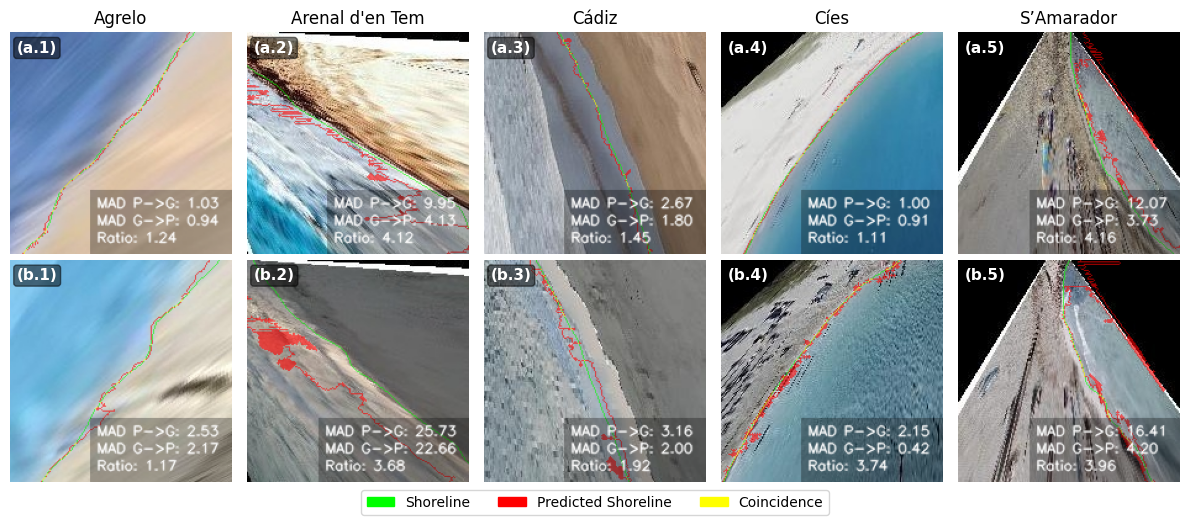

In [ ]:
import matplotlib.patches as mpatches

# Replace this with your actual station list and data structure
station_names = list(config.keys())
labels = ['(a.1)', '(a.2)', '(a.3)', '(a.4)', '(a.5)', '(b.1)', '(b.2)', '(b.3)', '(b.4)', '(b.5)']

# Define the crop size (width x height)
crop_size = (180, 180)  # Width x Height

# Create the figure
fig, axes = plt.subplots(2, len(station_names), figsize=(12, 5))  # Slightly wider

title_station_names = ["Agrelo", "Arenal d'en Tem", "Cádiz", "Cíes", "S’Amarador"]

config = {
    "agrelo": {
        "best_start": [250, 100],
        "best_second_start": [270, 100]
    }, 
    "arenaldentem": {
        "best_start": [60, 0],
        "best_second_start": [140, 70]
    },
    "cadiz": {
        "best_start": [240, 200],
        "best_second_start": [240, 200]
    },
    "cies": {
        "best_start": [150, 0],
        "best_second_start": [90, 0]
    },
    "samarador": {
        "best_start": [0, 0],
        "best_second_start": [0, 0]
    }
}

# Loop over stations
for i, station in enumerate(station_names):
    best_index = best_indexes[station]
    # Read image
    img_crop_best = get_image(predictions_path["global"], test_images_path, station, best_index, shoreline_pixel_mask = 1, shoreline_pixel_predicted_mask = 1, start_crop=config[station]['best_start'], crop_size=crop_size, bilstm=True)
    
    # worst_index = worst_indexes[station]
    worst_index = second_best_indexes[station]
    img_crop_worst = get_image(predictions_path["global"], test_images_path, station, worst_index, shoreline_pixel_mask = 1, shoreline_pixel_predicted_mask = 1, start_crop=config[station]['best_start'], crop_size=crop_size, bilstm=True)

    # Top row: RGB image
    axes[0][i].imshow(img_crop_best)
    axes[0][i].axis('off')
    axes[0][i].set_title(title_station_names[i])
    axes[0][i].text(5, 16, labels[i], fontsize=11, color='white', weight='bold', bbox=dict(facecolor='black', alpha=0.5, boxstyle='round,pad=0.2'))

    axes[1][i].imshow(img_crop_worst)
    axes[1][i].axis('off')
    # axes[1][i].set_title(title_station_names[i])
    axes[1][i].text(5, 16, labels[i+5], fontsize=11, color='white', weight='bold', bbox=dict(facecolor='black', alpha=0.5, boxstyle='round,pad=0.2'))

# Add color legend below the figure
legend_patches = [
    mpatches.Patch(color=np.array(CLASS_COLORS['Shoreline'])/255, label='Shoreline'),
    mpatches.Patch(color=np.array(CLASS_COLORS['Predicted_Shoreline'])/255, label='Predicted Shoreline'),
    mpatches.Patch(color=np.array(CLASS_COLORS['Coincidence'])/255, label='Coincidence'),
]
fig.legend(handles=legend_patches, loc='lower center', ncol=4, bbox_to_anchor=(0.5, -0.045))

# Layout
plt.tight_layout()
plt.show()

# Save the figure
fig.savefig(os.path.join("img", "example_prediction_bilstm_global.png"), bbox_inches='tight', dpi=300)

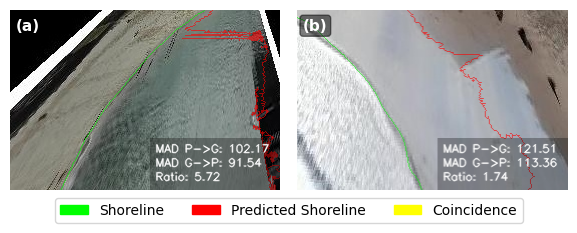

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import os

# Estacions seleccionades (pots canviar-les)
selected_stations = ["cies", "cadiz"]
labels = ['(a)', '(b)']

# Paràmetres visuals
crop_size = (270, 180)

config = {
    "agrelo": {
        "start": [250, 100]
    }, 
    "arenaldentem": {
        "start": [60, 0]
    },
    "cadiz": {
        "start": [80, 000]
    },
    "cies": {
        "start": [90, 0]
    },
    "samarador": {
        "start": [0, 0]
    }
}

# Crear figura 1x2
fig, axes = plt.subplots(1, 2, figsize=(5.9, 2.1))  # ajustat per una fila al TFM

# Pintar cada imatge
for i, station in enumerate(selected_stations):
    index = worst_indexes[station]  # o worst_indexes[station]
    start_crop = config[station]['start']  # Pots canviar-ho si vols un altre cropping

    img_crop = get_image(predictions_path["global"], test_images_path, station, index,
                         shoreline_pixel_mask=1,
                         shoreline_pixel_predicted_mask=1,
                         start_crop=start_crop,
                         crop_size=crop_size,
                         bilstm=True)

    axes[i].imshow(img_crop)
    axes[i].axis('off')
    # axes[i].set_title(titles[i])
    axes[i].text(5, 20, labels[i], fontsize=11, color='white', weight='bold',
                 bbox=dict(facecolor='black', alpha=0.5, boxstyle='round,pad=0.2'))

# Llegenda de colors
legend_patches = [
    mpatches.Patch(color=np.array(CLASS_COLORS['Shoreline']) / 255, label='Shoreline'),
    mpatches.Patch(color=np.array(CLASS_COLORS['Predicted_Shoreline']) / 255, label='Predicted Shoreline'),
    mpatches.Patch(color=np.array(CLASS_COLORS['Coincidence']) / 255, label='Coincidence'),
]
fig.legend(handles=legend_patches, loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.12))

# Layout compacte
plt.tight_layout()

# Mostrar i guardar
plt.show()
fig.savefig(os.path.join("img", "example_bad_predictions_bilstm_global.png"), bbox_inches='tight', dpi=300)


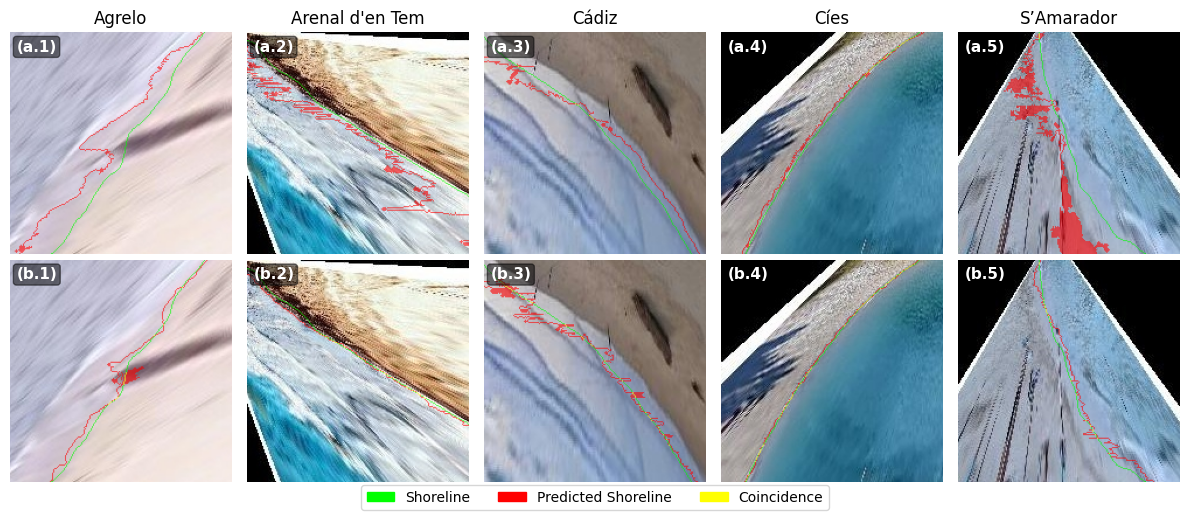

In [25]:

import matplotlib.patches as mpatches

# Replace this with your actual station list and data structure
station_names = list(config.keys())
labels = ['(a.1)', '(a.2)', '(a.3)', '(a.4)', '(a.5)', '(b.1)', '(b.2)', '(b.3)', '(b.4)', '(b.5)']

# Define the crop size (width x height)
crop_size = (190, 190)  # Width x Height

# Create the figure
fig, axes = plt.subplots(2, len(station_names), figsize=(12, 5))  # Slightly wider
title_station_names = ["Agrelo", "Arenal d'en Tem", "Cádiz", "Cíes", "S’Amarador"]

index_station = {
    "agrelo": 5,
    "arenaldentem": 2,
    "cadiz": 6,
    "cies": 9,
    "samarador": 0,
}

# Loop over stations
for i, station in enumerate(station_names):
    index = index_station[station]
    # Read image

    img_crop_unet = get_image(predictions_path["global"], test_images_path, station, index, shoreline_pixel_mask = 1, shoreline_pixel_predicted_mask = 1, crop_size=crop_size, three_classes=True)

    img_crop_attention = get_image(predictions_path["per-station"], test_images_path, station, index, shoreline_pixel_mask = 1, shoreline_pixel_predicted_mask = 1, crop_size=crop_size, three_classes=True)
    

    # Top row: RGB image
    axes[0,i].imshow(img_crop_unet)
    axes[0,i].axis('off')
    axes[0,i].set_title(title_station_names[i])
    
    axes[1,i].imshow(img_crop_attention)
    axes[1,i].axis('off')
    # axes[1,i].set_title(station)

    
    # axes[3,i].set_title(station)

    # # Bottom row: mask
    # axes[1, i].imshow(colored_mask)
    # axes[1, i].axis('off')

    # # Add text labels
    # axes[i].text(5, 30, labels[i], fontsize=11, color='white', weight='bold', bbox=dict(facecolor='black', alpha=0.5, boxstyle='round,pad=0.2'))
    axes[0, i].text(5, 16, labels[i], fontsize=11, color='white', weight='bold', bbox=dict(facecolor='black', alpha=0.5, boxstyle='round,pad=0.2'))
    axes[1, i].text(5, 16, labels[i+5], fontsize=11, color='white', weight='bold', bbox=dict(facecolor='black', alpha=0.5, boxstyle='round,pad=0.2'))

# Add color legend below the figure
legend_patches = [
    mpatches.Patch(color=np.array(CLASS_COLORS['Shoreline'])/255, label='Shoreline'),
    mpatches.Patch(color=np.array(CLASS_COLORS['Predicted_Shoreline'])/255, label='Predicted Shoreline'),
    mpatches.Patch(color=np.array(CLASS_COLORS['Coincidence'])/255, label='Coincidence'),
]
fig.legend(handles=legend_patches, loc='lower center', ncol=4, bbox_to_anchor=(0.5, -0.035))

# Layout
plt.tight_layout()
plt.show()

# Save the figure
fig.savefig(os.path.join("img", "example_prediction_bilstm.png"), bbox_inches='tight', dpi=300)